# 생체인증보안 주유연 홍채 2차 코드

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8283568578281749198
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10768720896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1868268098612688904
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [73]:
# 라이브러리 import
import PIL.Image as pilimg
import numpy as np
import glob
import matplotlib.pyplot as plt
import re

In [74]:
# 이미지 목록
images = glob.glob('./03_iris_training/*.png')
len(images)

128

In [75]:
r = re.compile('\d+')

img = [] # 이미지
label = [] # 라벨

for fname in images:
    l = r.findall(fname)[1]
    label.append(l)
    im = pilimg.open(fname)
    im = im.resize((int(im.width*0.3), int(im.height*0.3))) # 이미지 줄이기
    pix = np.array(im)
    img.append(pix)

In [76]:
X = np.array(img)
X.shape # img shape

(128, 172, 230, 3)

In [77]:
y = np.array(label, dtype='int32')
y # label

array([38, 12, 54, 56, 19, 51, 20, 48, 10, 45, 16, 13, 28, 29, 32, 34, 40,
       30, 59,  2, 59, 55, 51, 45, 61,  1, 15, 48, 35, 49, 64, 26, 38, 42,
       33,  5, 40, 25, 12, 56,  7, 27, 47, 33, 20, 57, 26, 43,  6, 23, 37,
       44, 17, 52, 21, 64, 27, 22, 31,  4, 10, 39, 19, 55, 41,  4, 58, 24,
        1, 18, 58, 49, 24, 53, 32,  9, 14, 14, 35, 36,  5,  2, 57, 54, 53,
       28, 60, 46, 37, 29, 46, 15, 36, 47, 43, 21, 30,  6, 44, 18, 50, 31,
       11,  3,  8, 22, 42, 50, 62, 41, 61, 63,  9,  3, 16,  7, 39, 60, 34,
       52, 17, 63, 23, 25, 11, 13,  8, 62], dtype=int32)

In [78]:
X[0].shape

(172, 230, 3)

(172, 230, 3)
38


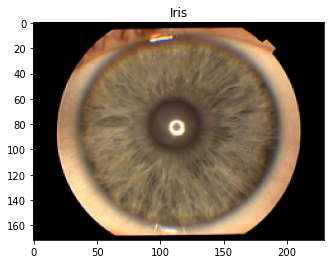

In [79]:
# 얼굴 이미지
plt.title('Iris')
plt.imshow(X[0])
print(X[0].shape)
print(y[0])

In [80]:
X[0].shape

(172, 230, 3)

In [81]:
X.shape

(128, 172, 230, 3)

## Data Augmentation

In [82]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.Add((-20,20)),
    iaa.Fliplr(0.5), # 수평
    iaa.Flipud(0.5) # 수직
], random_order=True)

def aug_data(X_data, y_data):
    augmentated_data = [] # 생성한 이미지
    augmentated_label = [] # 생성한 이미지의 라벨
    for i in range(len(X)):
        augs = [X[i]] * 19 # 이미지당 9개 추가 생성
        augs = seq.augment_images(augs)
        for aug in augs:
            augmentated_data.append(aug)
            augmentated_label.append(y_data[i])
    
    return augmentated_data, augmentated_label

In [83]:
x_d, y_d = aug_data(X, y) # 이미지 생성
print(len(x_d), len(y_d))

2432 2432


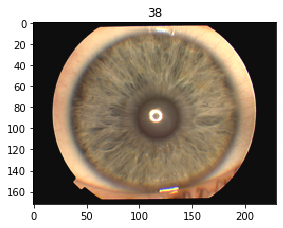

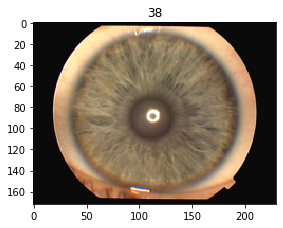

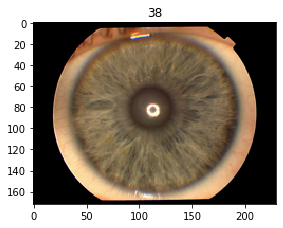

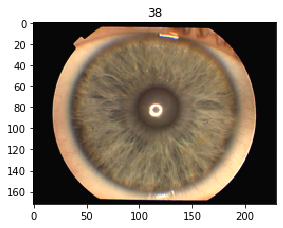

In [89]:
# 생성한 홍채 이미지
for i in range(4):
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,i+1)
    plt.title(y_d[i])
    plt.imshow(x_d[i], interpolation="nearest")
    plt.grid(False)

plt.show()

In [90]:
# 생성한 이미지
x_d = np.array(x_d)
y_d = np.array(y_d)
print(x_d.shape)
print(y_d.shape)

(2432, 172, 230, 3)
(2432,)


In [91]:
# 기존 이미지
print(X.shape)
print(y.shape)

(128, 172, 230, 3)
(128,)


In [92]:
# 기존 이미지, 생성 이미지 합치기
X_data = np.concatenate([X, x_d], axis=0)/255.
y_data = np.concatenate([y, y_d], axis=0)
print(X_data.shape)
print(y_data.shape)

(2560, 172, 230, 3)
(2560,)


# Data split

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, shuffle=True, stratify=y_data, random_state=101)

In [94]:
X_train=X_train.astype('float32')
y_train=y_train.astype('int32')
X_test=X_test.astype('float32')
y_test=y_test.astype('int32')

In [95]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2048, 172, 230, 3) (2048,) (512, 172, 230, 3) (512,)


In [96]:
# Input shape
X_train[0].shape

(172, 230, 3)

# Model

In [97]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Masking, Dense, Flatten, Dropout, Input
from tensorflow.keras.applications import ResNet50V2

In [98]:
def build_model():
    learning_rate = 0.0001
    METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy')
    ]
    input = Input(X_train[0].shape)
    base_model = ResNet50V2(include_top=False, input_tensor=input)
    
    for layer in base_model.layers[:44]:
        layer.trainable=False
    model = base_model.output
    model = MaxPooling2D()(model)
    
    model = Flatten()(model)
    model = Dense(512, activation='relu', kernel_regularizer='l2')(model)
    model = Dropout(0.5)(model)
    model = Dense(128, activation='relu')(model)
    
    output = Dense(65, activation='softmax')(model)
    
    model = tf.keras.Model(input,output)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=METRICS)
    return model

build_model().summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 172, 230, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 178, 236, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 86, 115, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 88, 117, 64)  0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [99]:
#Cross validation
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_history = [] # 결과 저장

def score_model(cv=None):
    if cv is None:
        cv = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
        
    i=0
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        i=i+1
        print('Fold #',i)
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]
        
        x,y,z,w = X_train_fold.shape
        print(y_train_fold)
        print(X_val_fold.shape)
        print(y_val_fold.shape)
        
        # to_categorical
        y_train_fold = to_categorical(y_train_fold, num_classes=65)
        y_val_fold = to_categorical(y_val_fold, num_classes=65)
        
        # Fit the model
        model = build_model()
        model_obj = model.fit(X_train_fold, y_train_fold,
                              epochs=100,
                              batch_size=128,
                              validation_data=(X_val_fold, y_val_fold),
                              verbose=1)
        model.save('./model/iris_model12_'+str(i)+'.h5')
        all_history.append(model_obj.history)

# Example of the model in action
score_model(cv=kf)

Fold # 1
[18 64  3 ... 19 10 42]
(512, 172, 230, 3)
(512,)
Epoch 1/100
12/12 [==============================] - 8s 468ms/step - loss: 15.4047 - accuracy: 0.0830 - val_loss: 13.4718 - val_accuracy: 0.0547
Epoch 2/100
12/12 [==============================] - 5s 411ms/step - loss: 11.1416 - accuracy: 0.5265 - val_loss: 12.2130 - val_accuracy: 0.1855
Epoch 3/100
12/12 [==============================] - 5s 412ms/step - loss: 9.1873 - accuracy: 0.8310 - val_loss: 10.9552 - val_accuracy: 0.3086
Epoch 4/100
12/12 [==============================] - 5s 412ms/step - loss: 8.1250 - accuracy: 0.9582 - val_loss: 9.7164 - val_accuracy: 0.4883
Epoch 5/100
12/12 [==============================] - 5s 413ms/step - loss: 7.5107 - accuracy: 0.9808 - val_loss: 8.6405 - val_accuracy: 0.6289
Epoch 6/100
12/12 [==============================] - 5s 414ms/step - loss: 7.0254 - accuracy: 0.9855 - val_loss: 7.7863 - val_accuracy: 0.6992
Epoch 7/100
12/12 [==============================] - 5s 414ms/step - loss: 6.6

12/12 [==============================] - 5s 424ms/step - loss: 1.0282 - accuracy: 1.0000 - val_loss: 1.0128 - val_accuracy: 0.9961
Epoch 58/100
12/12 [==============================] - 5s 421ms/step - loss: 0.9935 - accuracy: 1.0000 - val_loss: 0.9818 - val_accuracy: 0.9961
Epoch 59/100
12/12 [==============================] - 5s 427ms/step - loss: 0.9605 - accuracy: 1.0000 - val_loss: 0.9481 - val_accuracy: 0.9961
Epoch 60/100
12/12 [==============================] - 5s 423ms/step - loss: 0.9280 - accuracy: 1.0000 - val_loss: 0.9133 - val_accuracy: 1.0000
Epoch 61/100
12/12 [==============================] - 5s 421ms/step - loss: 0.8975 - accuracy: 1.0000 - val_loss: 0.8813 - val_accuracy: 1.0000
Epoch 62/100
12/12 [==============================] - 5s 421ms/step - loss: 0.8672 - accuracy: 1.0000 - val_loss: 0.8522 - val_accuracy: 0.9961
Epoch 63/100
12/12 [==============================] - 5s 424ms/step - loss: 0.8378 - accuracy: 1.0000 - val_loss: 0.8261 - val_accuracy: 0.9961
Epoch

12/12 [==============================] - 5s 420ms/step - loss: 5.0988 - accuracy: 0.9999 - val_loss: 4.9511 - val_accuracy: 0.9980
Epoch 14/100
12/12 [==============================] - 5s 418ms/step - loss: 4.8969 - accuracy: 0.9984 - val_loss: 4.7556 - val_accuracy: 1.0000
Epoch 15/100
12/12 [==============================] - 5s 423ms/step - loss: 4.7087 - accuracy: 0.9996 - val_loss: 4.5728 - val_accuracy: 1.0000
Epoch 16/100
12/12 [==============================] - 5s 421ms/step - loss: 4.5280 - accuracy: 1.0000 - val_loss: 4.4018 - val_accuracy: 1.0000
Epoch 17/100
12/12 [==============================] - 5s 423ms/step - loss: 4.3636 - accuracy: 0.9998 - val_loss: 4.2408 - val_accuracy: 1.0000
Epoch 18/100
12/12 [==============================] - 5s 422ms/step - loss: 4.2067 - accuracy: 1.0000 - val_loss: 4.0907 - val_accuracy: 1.0000
Epoch 19/100
12/12 [==============================] - 5s 423ms/step - loss: 4.0566 - accuracy: 0.9971 - val_loss: 3.9448 - val_accuracy: 1.0000
Epoch

Epoch 70/100
12/12 [==============================] - 5s 421ms/step - loss: 0.7130 - accuracy: 1.0000 - val_loss: 0.6933 - val_accuracy: 1.0000
Epoch 71/100
12/12 [==============================] - 5s 421ms/step - loss: 0.6885 - accuracy: 1.0000 - val_loss: 0.6705 - val_accuracy: 1.0000
Epoch 72/100
12/12 [==============================] - 5s 422ms/step - loss: 0.6653 - accuracy: 1.0000 - val_loss: 0.6483 - val_accuracy: 1.0000
Epoch 73/100
12/12 [==============================] - 5s 421ms/step - loss: 0.6423 - accuracy: 1.0000 - val_loss: 0.6262 - val_accuracy: 1.0000
Epoch 74/100
12/12 [==============================] - 5s 421ms/step - loss: 0.6204 - accuracy: 1.0000 - val_loss: 0.6047 - val_accuracy: 1.0000
Epoch 75/100
12/12 [==============================] - 5s 423ms/step - loss: 0.5994 - accuracy: 1.0000 - val_loss: 0.5844 - val_accuracy: 1.0000
Epoch 76/100
12/12 [==============================] - 5s 422ms/step - loss: 0.5789 - accuracy: 1.0000 - val_loss: 0.5642 - val_accuracy:

12/12 [==============================] - 5s 420ms/step - loss: 3.0343 - accuracy: 0.9990 - val_loss: 2.9851 - val_accuracy: 0.9883
Epoch 27/100
12/12 [==============================] - 5s 421ms/step - loss: 2.9271 - accuracy: 0.9996 - val_loss: 2.8719 - val_accuracy: 0.9902
Epoch 28/100
12/12 [==============================] - 5s 424ms/step - loss: 2.8266 - accuracy: 0.9995 - val_loss: 2.7701 - val_accuracy: 0.9902
Epoch 29/100
12/12 [==============================] - 5s 422ms/step - loss: 2.7266 - accuracy: 1.0000 - val_loss: 2.6887 - val_accuracy: 0.9902
Epoch 30/100
12/12 [==============================] - 5s 422ms/step - loss: 2.6350 - accuracy: 0.9992 - val_loss: 2.5950 - val_accuracy: 0.9922
Epoch 31/100
12/12 [==============================] - 5s 420ms/step - loss: 2.5447 - accuracy: 0.9993 - val_loss: 2.4976 - val_accuracy: 0.9922
Epoch 32/100
12/12 [==============================] - 5s 421ms/step - loss: 2.4591 - accuracy: 0.9992 - val_loss: 2.4150 - val_accuracy: 0.9902
Epoch

Epoch 83/100
12/12 [==============================] - 5s 424ms/step - loss: 0.4454 - accuracy: 0.9995 - val_loss: 0.4461 - val_accuracy: 0.9922
Epoch 84/100
12/12 [==============================] - 5s 421ms/step - loss: 0.4330 - accuracy: 1.0000 - val_loss: 0.4254 - val_accuracy: 1.0000
Epoch 85/100
12/12 [==============================] - 5s 420ms/step - loss: 0.4187 - accuracy: 1.0000 - val_loss: 0.4116 - val_accuracy: 1.0000
Epoch 86/100
12/12 [==============================] - 5s 423ms/step - loss: 0.4052 - accuracy: 1.0000 - val_loss: 0.3977 - val_accuracy: 1.0000
Epoch 87/100
12/12 [==============================] - 5s 422ms/step - loss: 0.3911 - accuracy: 1.0000 - val_loss: 0.3845 - val_accuracy: 1.0000
Epoch 88/100
12/12 [==============================] - 5s 425ms/step - loss: 0.3776 - accuracy: 1.0000 - val_loss: 0.3696 - val_accuracy: 1.0000
Epoch 89/100
12/12 [==============================] - 5s 429ms/step - loss: 0.3643 - accuracy: 1.0000 - val_loss: 0.3564 - val_accuracy:

12/12 [==============================] - 5s 420ms/step - loss: 1.9570 - accuracy: 0.9987 - val_loss: 1.9137 - val_accuracy: 0.9980
Epoch 40/100
12/12 [==============================] - 5s 420ms/step - loss: 1.8895 - accuracy: 0.9997 - val_loss: 1.8539 - val_accuracy: 0.9902
Epoch 41/100
12/12 [==============================] - 5s 420ms/step - loss: 1.8262 - accuracy: 0.9996 - val_loss: 1.7893 - val_accuracy: 0.9980
Epoch 42/100
12/12 [==============================] - 5s 421ms/step - loss: 1.7676 - accuracy: 0.9994 - val_loss: 1.7263 - val_accuracy: 0.9980
Epoch 43/100
12/12 [==============================] - 5s 423ms/step - loss: 1.7074 - accuracy: 1.0000 - val_loss: 1.6720 - val_accuracy: 0.9980
Epoch 44/100
12/12 [==============================] - 5s 424ms/step - loss: 1.6504 - accuracy: 1.0000 - val_loss: 1.6177 - val_accuracy: 0.9980
Epoch 45/100
12/12 [==============================] - 5s 420ms/step - loss: 1.5970 - accuracy: 0.9987 - val_loss: 1.5675 - val_accuracy: 0.9980
Epoch

Epoch 96/100
12/12 [==============================] - 5s 420ms/step - loss: 0.3060 - accuracy: 1.0000 - val_loss: 0.3017 - val_accuracy: 0.9980
Epoch 97/100
12/12 [==============================] - 5s 422ms/step - loss: 0.2955 - accuracy: 1.0000 - val_loss: 0.2919 - val_accuracy: 0.9980
Epoch 98/100
12/12 [==============================] - 5s 420ms/step - loss: 0.2853 - accuracy: 1.0000 - val_loss: 0.2823 - val_accuracy: 0.9980
Epoch 99/100
12/12 [==============================] - 5s 418ms/step - loss: 0.2756 - accuracy: 1.0000 - val_loss: 0.2721 - val_accuracy: 0.9980
Epoch 100/100
12/12 [==============================] - 5s 427ms/step - loss: 0.2664 - accuracy: 1.0000 - val_loss: 0.2629 - val_accuracy: 0.9980


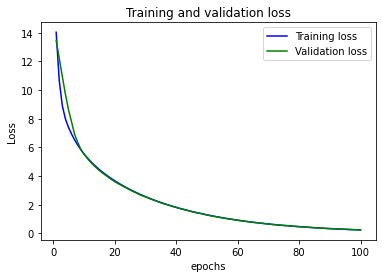

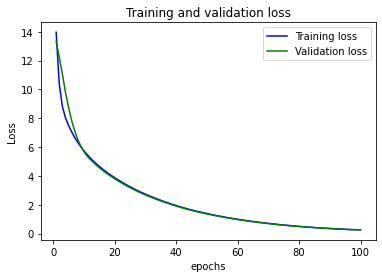

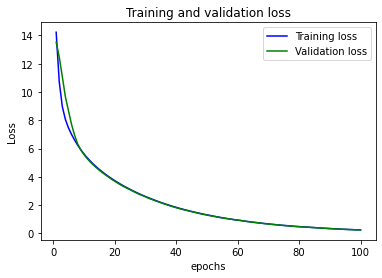

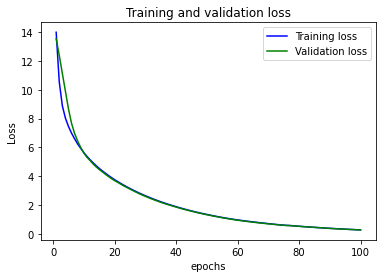

In [100]:
# Loss
for i in range(4):
    loss = all_history[i].get('loss') # train
    val_loss = all_history[i].get('val_loss') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation loss') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

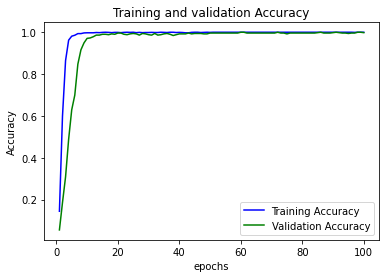

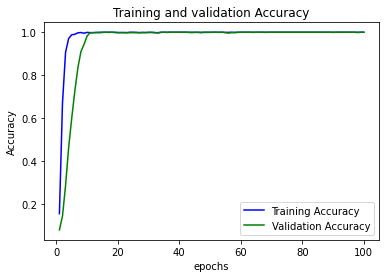

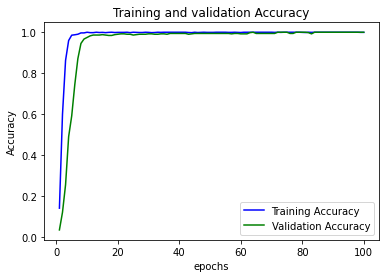

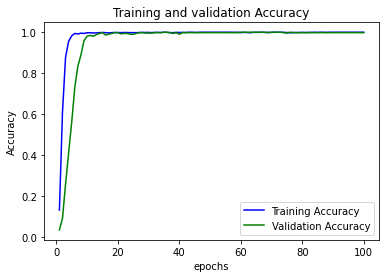

In [101]:
# Accuracy
for i in range(4):
    loss = all_history[i].get('accuracy') # train
    val_loss = all_history[i].get('val_accuracy') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training Accuracy')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation Accuracy') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [102]:
from tensorflow.keras.models import load_model
model = load_model('./model/iris_model12_4.h5') ## 가장 학습과정이 좋아보이는 모델 로드

In [103]:
preds = np.argmax(model.predict(X_test), axis=1)
preds

array([39, 31, 13, 15, 47, 22, 42, 35, 29, 10, 53, 32,  5, 23, 45,  5, 40,
        1, 28, 51, 39, 57,  3,  6, 22, 34, 51, 13, 54, 51, 22,  3,  8,  2,
       64, 26, 56, 42,  7, 43, 43, 25, 11, 52, 48, 35, 45, 27, 60, 23, 15,
       42,  9, 14, 12, 58, 41, 35,  4,  6,  4,  2,  1, 44,  5, 24, 21, 33,
       28, 31, 20, 26, 26, 50, 42, 18,  9, 18, 27, 50, 40, 22, 26, 63, 63,
       40, 53, 12, 57, 60,  7, 45, 21, 46, 52, 29, 32, 46, 37, 26, 13, 13,
       19, 11, 13,  4,  4, 25, 40, 21, 14, 39, 14, 23, 59, 42, 13, 34, 14,
       56, 39, 29,  2, 33, 23, 62, 33, 11, 38, 43, 35, 52, 30, 45, 48, 28,
       25, 46, 10, 33, 63, 53, 16, 52,  8, 12, 61, 55, 27, 61, 33, 29, 30,
       20,  3, 40, 17,  3, 44, 55, 23, 52, 57, 41, 42, 34, 21, 47,  8, 43,
       37, 64, 37, 21, 58, 36, 50, 49, 50, 61, 47, 33, 55,  6, 64, 18,  6,
        1, 21, 64,  6, 59, 15, 58, 48, 25, 18, 22, 19, 51, 30, 47, 22,  4,
       19, 44, 17, 59, 24, 31, 63, 44, 16, 51, 26, 62, 31, 55, 37, 46, 15,
       32, 63,  9, 14, 49

In [104]:
y_test

array([39, 31, 13, 15, 47, 22, 42, 35, 29, 10, 53, 32,  5, 23, 45,  5, 40,
        1, 28, 51, 39, 57,  3,  6, 22, 34, 51, 13, 54, 48, 22,  3,  8,  2,
       64, 26, 56, 42,  7, 43, 43, 25, 11, 52, 48, 35, 45, 27, 60, 23, 15,
       42,  9, 14, 12, 58, 41, 35,  4,  6,  4,  2,  1, 44,  5, 24, 21, 33,
       28, 31, 20, 26, 26, 50, 42, 18,  9, 18, 27, 50, 40, 22, 26, 63, 63,
       40, 53, 12, 57, 60,  7, 45, 21, 46, 52, 29, 32, 46, 37, 26, 13, 13,
       19, 11, 13,  4,  4, 25, 40, 21, 14, 39, 14, 23, 59, 42, 13, 34, 14,
       56, 39, 29,  2, 33, 23, 62, 33, 11, 38, 43, 35, 52, 30, 45, 48, 28,
       25, 46, 10, 33, 63, 53, 16, 52,  8, 12, 61, 55, 27, 61, 33, 29, 30,
       20,  3, 40, 17,  3, 44, 55, 23, 52, 57, 41, 42, 34, 21, 47,  8, 43,
       37, 64, 37, 21, 58, 36, 50, 49, 50, 61, 47, 33, 55,  6, 64, 18,  6,
        1, 21, 64,  6, 59, 15, 58, 48, 25, 18, 22, 19, 51, 30, 47, 22,  4,
       19, 44, 17, 59, 24, 31, 63, 44, 16, 51, 26, 62, 31, 55, 37, 46, 15,
       32, 63,  9, 14, 49

(172, 230, 3)
예측:  39
실제:  39


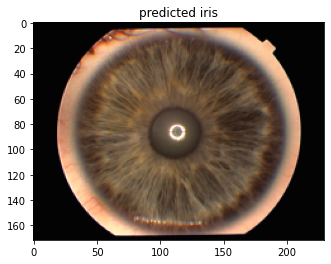

In [105]:
# 예측결과
plt.title('predicted iris')
this_img = X_test[0]
plt.imshow(this_img)
print(this_img.shape)
print('예측: ', preds[0])
print('실제: ', y_test[0])

# Result

In [106]:
from sklearn.metrics import mean_squared_error
# rmse
rmse = np.sqrt(mean_squared_error(y_test, preds)) 
print("RMSE: %f" % (rmse))

RMSE: 0.187500


In [107]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,preds))

[[8 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 8 0 0]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 0 8]]


In [108]:
from sklearn.metrics import classification_report
print(classification_report(y_test,preds, zero_division=1))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00         8
          17       1.00      1.00      1.00         8
          18       1.00    

## Test

In [109]:
images = glob.glob('./03_iris_test/*.png')
len(images)

256

In [110]:
r = re.compile('\d+')

img = [] # 이미지
img_num = [] # 이미지 번호

for fname in images:
    num = r.findall(fname)[1]
    img_num.append(num)
    im = pilimg.open(fname)
    im = im.resize((int(im.width*0.3), int(im.height*0.3))) #2^6x3^2 2^8x3
    pix = np.array(im)
    img.append(pix)

(172, 230, 3)
51


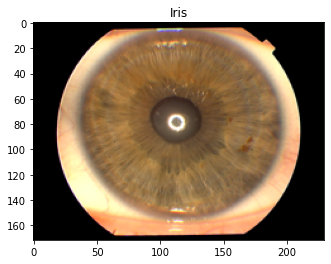

In [111]:
# 얼굴 이미지
plt.title('Iris')
plt.imshow(img[0])
print(img[0].shape)
print(img_num[0])

In [112]:
X = np.array(img)
X = X/255.
X = X.astype('float32')

In [113]:
preds = np.argmax(model.predict(X), axis=1)
preds

array([49, 48, 48, 35, 23, 34, 35, 61, 61, 57, 22,  9, 19, 40, 51, 32,  1,
       41, 52, 35, 54, 28, 37, 30, 19, 45, 28, 48, 58,  5, 36,  8, 61, 59,
       23, 28, 23, 30, 19, 34, 12, 45, 10, 15, 29, 36, 54, 31,  6, 23, 21,
       19, 24, 14, 43, 32, 22, 14, 21, 13,  4, 58,  9, 62, 25, 58,  3, 42,
       27, 54, 33,  5, 29, 27, 61, 64, 39, 10, 18,  9, 27, 50, 50, 59,  6,
       47, 62,  3, 26, 45, 32, 14, 46, 58,  6, 20, 64, 50, 63, 56, 12, 34,
       57, 17,  2, 22, 49, 18, 49, 24, 10, 15, 28, 40, 12,  8, 33,  5, 47,
       23, 31, 32, 30,  2, 40, 43, 17, 53, 33, 42, 48, 40, 38, 56, 54, 57,
        6, 24, 41, 18, 42, 21, 15, 38,  8, 55, 61, 43, 37, 39, 56, 45, 20,
       51, 15, 58, 24, 52, 64, 62, 44, 28, 62, 38, 52, 13, 11, 60, 58, 63,
       31,  7, 46,  9,  8, 37,  3, 26, 29, 61, 64, 47, 59, 46, 13, 11, 41,
       20, 17, 62, 17, 63, 51, 49, 50, 22,  4, 37, 29,  1, 59, 10,  3,  1,
       13,  4, 41, 30, 16, 12, 43, 11, 46, 53,  2, 27, 36, 51, 26, 57, 21,
       39, 31, 16, 16,  4

In [114]:
np.set_printoptions(precision=6, suppress=True) # 소수점표기

In [115]:
# pre = model.predict(X)
# pre[2]

In [116]:
import pandas as pd
res_df = pd.DataFrame(img_num, columns=['Image'], dtype='int32')
res_df['Answer'] = pd.Series(preds, dtype='int32')
res_df.sort_values(by=['Image'], axis=0, inplace=True)
res_df

,Image,Answer
92,1,46
83,2,59
245,3,26
212,4,46
217,5,51
...,...,...
141,252,21
229,253,14
177,254,26
25,255,45


In [117]:
res_df['Answer'].value_counts()

61    6
58    6
62    5
28    5
22    5
     ..
42    3
25    3
60    3
44    2
53    2
Name: Answer, Length: 64, dtype: int64

In [118]:
res_df.to_csv('./1871085_홍채_2차_답안12.csv', index=False)